1. Analysis: Frame the problem and look at the big picture
Find a problem/task that everyone in the group finds interesting
Define the objective in business terms
How should you frame the problem (supervised/unsupervised etc.)?
How should performance be measured?


Almost everyone today uses technology to stream movies and television shows. While figuring out what to stream next can be daunting, recommendations are often made based on a viewer’s history and preferences.
So Our goal is to build a recommendation system that recommends movies to the users based on their previous ratings for other movies.
We will be using the MovieLens dataset to build a recommendation system using the collaborative filtering technique.

Data source:
MovieLens Latest Datasets
These datasets will change over time, and are not appropriate for reporting research results. We will keep the download links stable for automated downloads. We will not archive or make available previously released versions.

Small: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018.

README.html
ml-latest-small.zip (size: 1 MB)
Full: approximately 33,000,000 ratings and 2,000,000 tag applications applied to 86,000 movies by 330,975 users. Includes tag genome data with 14 million relevance scores across 1,100 tags. Last updated 9/2018.

README.html
ml-latest.zip (size: 335 MB)
Permalink: https://grouplens.org/datasets/movielens/latest/



To install Surprise, run the following command in your terminal:
conda install -c conda-forge scikit-surprise

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as train_test_split_sklearn

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline

from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import  cross_validate
from wordcloud import WordCloud


## 1. Data Exploration and Preprocessing

Load and Explore Data: Import the CSV files and explore the data to understand the structure and types of data you're dealing with.
Data Cleaning: Handle missing values, remove duplicates, and correct any inconsistencies in the data.

In [2]:
# Load the data
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')
links = pd.read_csv('ml-latest-small/links.csv')

In [3]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [4]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [5]:
tags.head(3)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


In [6]:
links.head(3)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


In [7]:
# Check the shape of the data
print('Shape of Movies data: ', movies.shape)
print('Shape of Ratings data: ', ratings.shape)
print('Shape of Tags data: ', tags.shape)
print('Shape of Links data: ', links.shape)


Shape of Movies data:  (9742, 3)
Shape of Ratings data:  (100836, 4)
Shape of Tags data:  (3683, 4)
Shape of Links data:  (9742, 3)


In [8]:
#  Join the movies and ratings dataframes using the movieId column
movies_ratings = pd.merge(movies, ratings, on='movieId')
movies_ratings.head(3)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946


In [9]:
# Find any missing values in the data
movies_ratings.isnull().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [10]:
#Checking for any duplicate rows
movies_ratings.duplicated().sum()

0

In [11]:
# Check the data types of the columns
movies_ratings.dtypes

movieId        int64
title         object
genres        object
userId         int64
rating       float64
timestamp      int64
dtype: object

We don't need the timestamp column, so we can drop it.

In [12]:
# Drop the timestamp column
movies_ratings.drop('timestamp', axis=1, inplace=True)
movies_ratings.head(1)

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0


We can see that the genres column contains a list of genres for each movie. We can split this column into multiple columns, one for each genre.
And use one-hot encoding to convert the categorical variables into a form that could be provided to ML algorithms to do a better job in prediction.

In [13]:
movies_ratings['genres'] = movies_ratings['genres'].astype(str)
# Split the genres string into a list of genres
movies_ratings['genres'] = movies_ratings['genres'].str.split('|')
movies_ratings.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,4.0
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7,4.5
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15,2.5
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17,4.5


In [14]:
exploded_genres = movies_ratings.explode('genres')
genre_dummies = pd.get_dummies(exploded_genres['genres'])

In [15]:
genre_dummies = genre_dummies.groupby(exploded_genres.index).sum()
movies_ratings = pd.concat([movies_ratings, genre_dummies], axis=1)
movies_ratings.drop('genres', axis=1, inplace=True)
movies_ratings.head()

,movieId,title,userId,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1,4.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,Toy Story (1995),5,4.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,Toy Story (1995),7,4.5,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,Toy Story (1995),15,2.5,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,Toy Story (1995),17,4.5,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# First lets see which type of genres have more ratings
genre_count = movies_ratings.iloc[:, 5:].sum().sort_values(ascending=False)

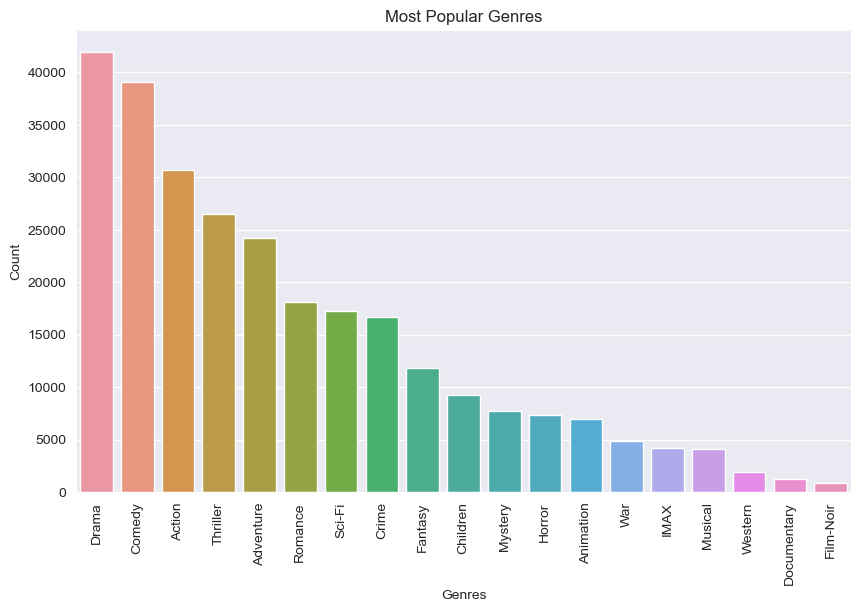

In [17]:
#Plotting the genres 
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_count.index, y=genre_count.values)
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Most Popular Genres')
plt.show()

From the Bar plot we can see that Drama, Comedy, Action, Thriller and Adventure genre have the most number of rating.

In [18]:
# Average Ratings per Genre 
genre_avg_rating = (movies_ratings.iloc[:, 5:].multiply(movies_ratings['rating'], axis="index")).sum() / genre_count

# Sorting genres by average rating
sorted_genre_avg_rating = genre_avg_rating.sort_values(ascending=False)

# Display the results

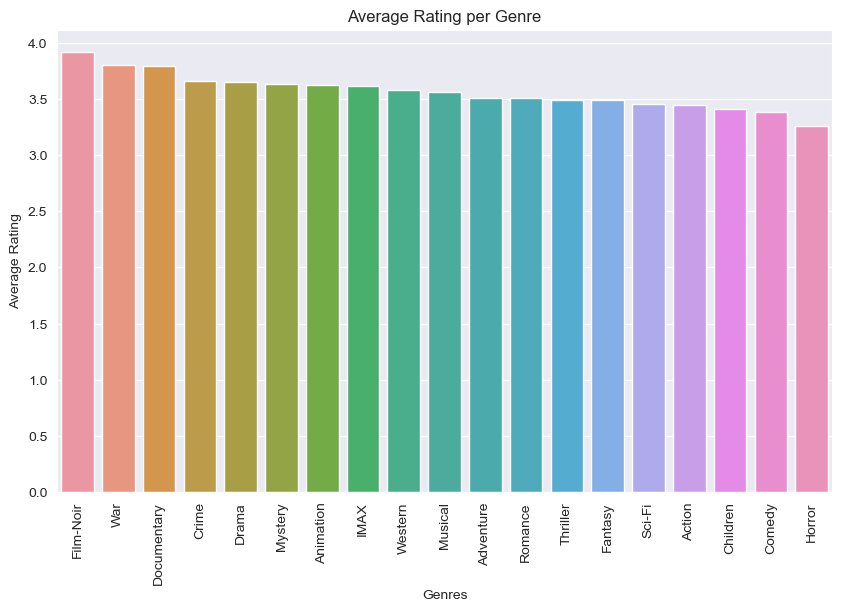

In [19]:
#Plotting the genres
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_genre_avg_rating.index, y=sorted_genre_avg_rating.values)
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Average Rating')
plt.title('Average Rating per Genre')
plt.show()

This gives us an uniques insight that the people who watch Niche genre movies (Film-Noir, Documentary, War) are more likely to have high average ratings. Whereas the people who watch movies in the Horror genre are more likely to give low ratings. 
Drama and Crime genres also show strong average ratings, aligning with their popularity in terms of movie counts.
Whereas genre like Horror and comedy have low average ratings, even though they are popular in terms of movie counts, it might be because there is huge variation in the quality of movies in these genres. And all type of movies are grouped under the same genre.

Things to keep in mind:
1. While popular genre is one thing to consider, it is also important to consider the quality of movies in that genre.
2. For users who rate Documentaries or Film-Noir highly, the system can prioritize similar high-rated but less popular genres. 
3. Users who prefer niche, high-rated genres can be grouped for more targeted recommendations.
4. If a user is mostly watching popular genre movies, then the system can recommend some popular movies from Niche genre to see if user will like it.

In [20]:
# the number of ratings per movie
movie_rating_count = movies_ratings.groupby('movieId')['rating'].count().sort_values(ascending=False)
movie_rating_count.head()

movieId
356     329
318     317
296     307
593     279
2571    278
Name: rating, dtype: int64

We can see that the movie with the most number of ratings is Forrest Gump (1994) with 329 ratings. 

In [21]:
#  the number of rating given by each user 
user_rating_count = movies_ratings.groupby('userId')['rating'].count().sort_values(ascending=False)
user_rating_count.head()

userId
414    2698
599    2478
474    2108
448    1864
274    1346
Name: rating, dtype: int64

Some users are much more active in rating movies than others. 

In [22]:
# Want to see average rating per movie 
movie_avg_rating = movies_ratings.groupby('movieId')['rating'].mean().sort_values(ascending=False)
movie_avg_rating.head()

movieId
88448     5.0
100556    5.0
143031    5.0
143511    5.0
143559    5.0
Name: rating, dtype: float64

In [23]:
# Want to see average ratting and combine with number of ratings per movie
movie_avg_rating_count = pd.concat([movie_avg_rating, movie_rating_count], axis=1)
movie_avg_rating_count.columns = ['AverageRating', 'NumberOfRating']
movie_avg_rating_count.head()

,AverageRating,NumberOfRating
movieId,,
88448,5.0,1
100556,5.0,1
143031,5.0,1
143511,5.0,1
143559,5.0,1


Looking at this we can see that this dataset contains movies that have been rated by a lot of users, as well as movies that have been rated by very few users. When the movie is only rated by one user that will be totally useless for our recommendation system. 
In our above table the movie with the most number of ratings is Forrest Gump (1994) with 329 ratings, and the least is 1. 
SO we will need to find a number for minimum number of ratings per movie to be considered. 

## Lets try to find outliers in the data

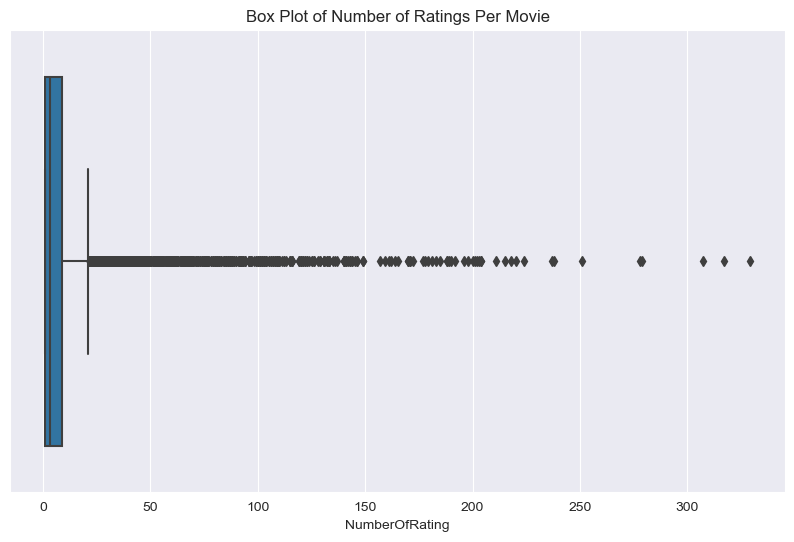

In [24]:
# Box plot for the number of ratings per movie
plt.figure(figsize=(10, 6))
sns.boxplot(x= movie_rating_count)
plt.title('Box Plot of Number of Ratings Per Movie')
plt.xlabel('NumberOfRating')
plt.show()

We can see that there are a lot of outliers in the data. Even though it looks like there are few to none outliers below Q1 , From the above table we can see that there are movies with only 1 rating. Which I think they are outliers.

In [25]:
# To find the number of outliers below Q1 
Q1 = movie_rating_count.quantile(0.25)
Q3 = movie_rating_count.quantile(0.75)
IQR = Q3 - Q1

In [26]:
Q1

1.0

Q1 is 1.0 , if we consider anything below 1.0 as outlier then we will not be removing any movies from our dataset.
So we will consider anything below 5.0 as outlier.

In [27]:
# To find the number of outliers above Q3
Q3

9.0

We cannot remove the outliers above Q3 because we will be removing a lot of movies from our dataset. So We will find Upper bound and lower bound to find outliers.

In [28]:
movie_rating_count.describe()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: rating, dtype: float64

From the above table we can see that the mean is 10.37 and the standard deviation is 22.40. 
while some movies have ratings close to the average number, there are movies that have much higher numbers of ratings, indicating a wide dispersion in our dataset.
It shows that our data follow long-tailed distribution. 

In [29]:
# Lets see how many movies are rated by less than 5 users
movie_rating_count[movie_rating_count < 5.0].count()

6074

It puts us on trouble because we have 6074 movies that are rated by less than 5 users. Our total number of movies is 9724. 


In [30]:
# Lets see how many movies are rated by only one user
movie_rating_count[movie_rating_count == 1.0].count()

3446

Lets try to Transform the data to reduce the skewness and make it more normal distribution.

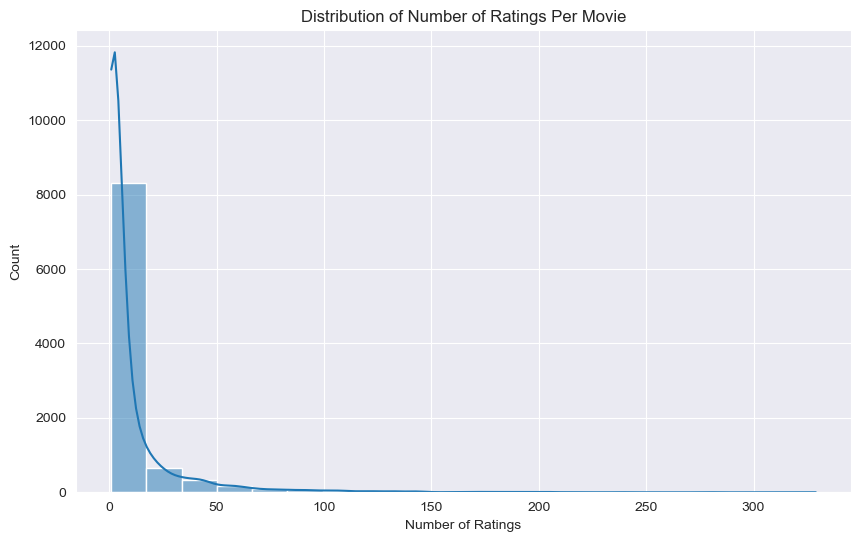

In [31]:
#Plotting the distribution of the number of ratings per movie
plt.figure(figsize=(10, 6))
sns.histplot(movie_rating_count, bins=20, kde=True)
plt.title('Distribution of Number of Ratings Per Movie')
plt.xlabel('Number of Ratings')
plt.show()


Since the data is strongly right skewed, we can apply log transformation to reduce the skewness.

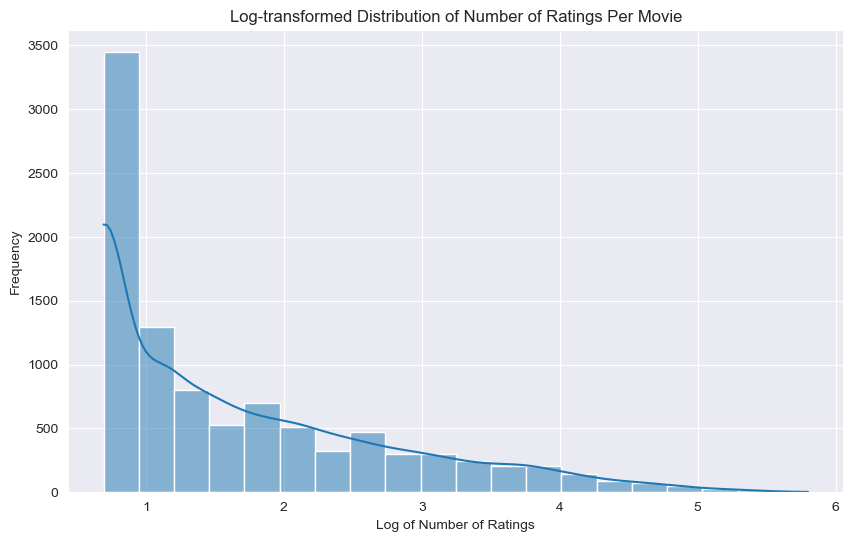

In [32]:
log_movie_rating_count = np.log1p(movie_rating_count)  # log1p is used to handle zero ratings as log(0) is undefined

#Plotting the log-transformed distribution of the number of ratings per movie
plt.figure(figsize=(10, 6))
sns.histplot(log_movie_rating_count, bins=20, kde=True)
plt.title('Log-transformed Distribution of Number of Ratings Per Movie')
plt.xlabel('Log of Number of Ratings')
plt.ylabel('Frequency')
plt.show()

We can see that the log-transformed data is more normally distributed than the original data.

In [33]:
log_movie_rating_count.describe()

count    9724.000000
mean        1.651746
std         1.074146
min         0.693147
25%         0.693147
50%         1.386294
75%         2.302585
max         5.799093
Name: rating, dtype: float64

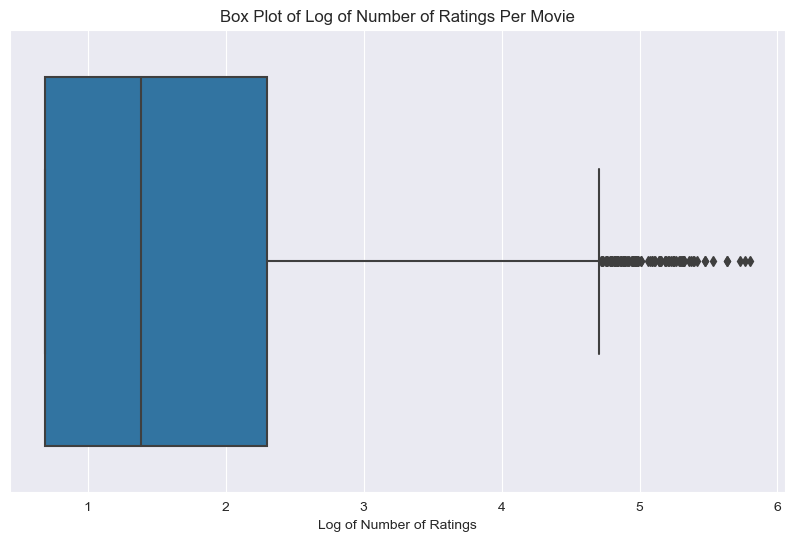

In [34]:
# Lets plot the box plot for the log-transformed data
plt.figure(figsize=(10, 6))
sns.boxplot(x= log_movie_rating_count)
plt.title('Box Plot of Log of Number of Ratings Per Movie')
plt.xlabel('Log of Number of Ratings')
plt.show()

Even though data is more normally distributed, we can not decide the lower bound. As already mentioned the data is long-tailed distribution. So we will try to find the other way to see the outliers for low ratings. 
For the higher ratings we believe if the movie is rated high it just meant that the movie is good. So we will not consider the outliers for higher ratings. **FOR NOW**


# First we will remove any outliers from user rating then we will come back to movies. 


In [35]:
user_rating_count.describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: rating, dtype: float64

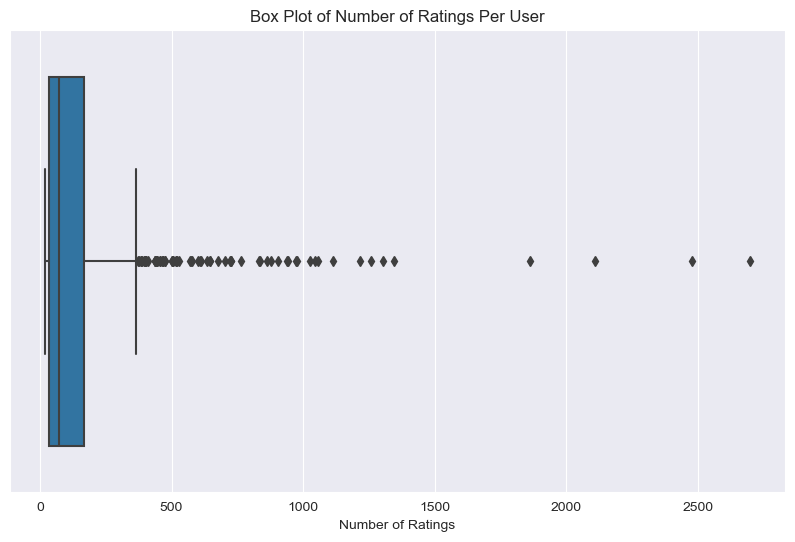

In [36]:
#lets box plot the distribution of the number of ratings per user
plt.figure(figsize=(10, 6))
sns.boxplot(x=user_rating_count) 
plt.title('Box Plot of Number of Ratings Per User')
plt.xlabel('Number of Ratings')
plt.show()

In [37]:
# lets find the outliers for lower ratings 
Q1 = user_rating_count.quantile(0.25)
Q3 = user_rating_count.quantile(0.75)
IQR = Q3 - Q1
print('Q1: ', Q1, '\nQ3: ', Q3, '\nIQR: ', IQR)

Q1:  35.0 
Q3:  168.0 
IQR:  133.0


In [38]:
# lets find the upper bound and lower bound
upper_bound = Q3 + 1.5 * IQR
# Since we cannot have a negative number of ratings, we will set the lower bound to 10th percentile
lower_bound = user_rating_count.quantile(0.10)
print('Upper Bound: ', upper_bound, '\nLower Bound: ', lower_bound)

Upper Bound:  367.5 
Lower Bound:  24.0


In [39]:
# lets count the number of outliers
user_rating_count[user_rating_count < lower_bound].count()

56

In [40]:
user_rating_count[user_rating_count > upper_bound].count()

70

In [41]:
# lets find the outliers for both lower and upper bound 
potential_outliers_user_ids = user_rating_count[(user_rating_count < lower_bound) | (user_rating_count > upper_bound)]

In [42]:
# lets remove the outliers from the movies_ratings dataframe 
print('Shape of movies_ratings dataframe before removing outliers: ', movies_ratings.shape)
movies_ratings_filtered = movies_ratings[
    ~movies_ratings['userId'].isin(potential_outliers_user_ids)
]
print('Shape of movies_ratings dataframe after removing outliers: ', movies_ratings_filtered.shape)

Shape of movies_ratings dataframe before removing outliers:  (100836, 24)
Shape of movies_ratings dataframe after removing outliers:  (93146, 24)


 This 'movies_ratings_filtered' dataframe now excludes the users who were considered outliers

# lets deep into tag data 

In [43]:
# lets check for missing values
tags.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

Lets see what are the most popular tags 

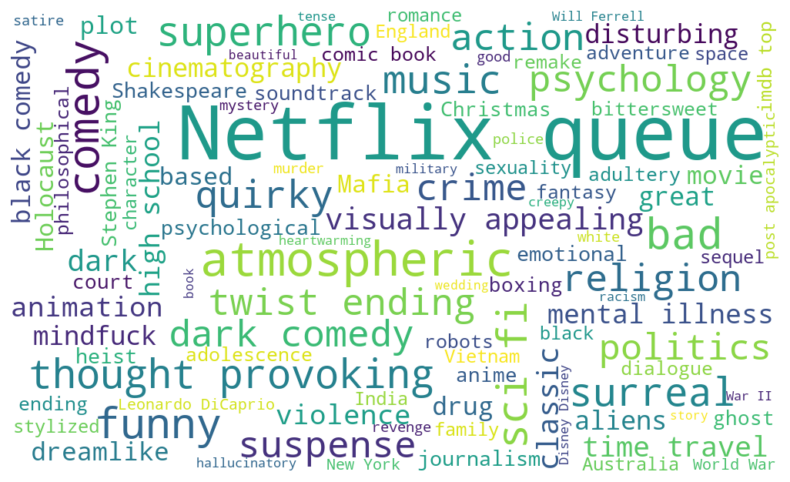

In [44]:
text = " ".join(tags["tag"])

wordcloud = WordCloud(width=1000, height=600, background_color="white", contour_color='steelblue', max_words=100).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

There are some niche tags and some more popular tags. It also makes sense that most popular tags are related to the genre of the movie.

In [45]:
# lets remove timestamp column
tags.drop('timestamp', axis=1, inplace=True)

First before merging we like to see how many movies have tags and how many movies have no tags. and how many tags have no movies in our movies_ratings_filtered dataframe.

In [46]:
# Convert the 'movieId' columns from both DataFrames to sets
movie_ids_from_ratings = set(movies_ratings_filtered['movieId'].unique())
movie_ids_from_tags = set(tags['movieId'].unique())

# Find movie IDs in 'movies_ratings_filtered' that have no tags
movies_with_no_tags = movie_ids_from_ratings - movie_ids_from_tags

# Find movie IDs in 'tags' that have no corresponding movie in 'movies_ratings_filtered'
tags_with_no_movies = movie_ids_from_tags - movie_ids_from_ratings

# Print the results
print(f"Movies with no tags: {len(movies_with_no_tags)}")
print(f"Tags with no corresponding movies: {len(tags_with_no_movies)}")
print(f"Total number of movies: {len(movie_ids_from_ratings.union(movie_ids_from_tags))}")
print(f"Total number of tags: {len(tags['movieId'].unique())}")

Movies with no tags: 7913
Tags with no corresponding movies: 131
Total number of movies: 9485
Total number of tags: 1572


Looking at the result , we believe we should not merge the tags dataframe with movies_ratings_filtered dataframe.

# Handling the missing genre values

In [47]:
# Count the number of movies with '(no genres listed)'
movies_without_genre= movies_ratings_filtered[movies_ratings_filtered['(no genres listed)'] == 1]
print(f"Number of movies with '(no genres listed)': {len(movies_without_genre)}")
movies_without_genre.head()

Number of movies with '(no genres listed)': 44


,movieId,title,userId,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
97487,114335,La cravate (1957),50,3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98182,122888,Ben-hur (2016),567,0.5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98217,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,62,3.5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98218,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,111,3.5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98219,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,212,3.5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# Drop the movies that are in movies_without_genre from movies_ratings_filtered
print(f"Shape of movies_ratings_filtered before dropping movies with '(no genres listed)': {movies_ratings_filtered.shape}")
movies_ratings_filtered = movies_ratings_filtered[
    ~movies_ratings_filtered['movieId'].isin(movies_without_genre['movieId'])
]

print(f"Shape of movies_ratings_filtered after dropping movies with '(no genres listed)': {movies_ratings_filtered.shape}")

Shape of movies_ratings_filtered before dropping movies with '(no genres listed)': (93146, 24)
Shape of movies_ratings_filtered after dropping movies with '(no genres listed)': (93102, 24)


In [49]:
# lets drop the '(no genres listed)' column
movies_ratings_filtered.drop('(no genres listed)', axis=1, inplace=True)
movies_ratings_filtered.head()

,movieId,title,userId,rating,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1,4.0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Toy Story (1995),5,4.0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Toy Story (1995),7,4.5,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,Toy Story (1995),15,2.5,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,Toy Story (1995),17,4.5,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


## Handling movie with only one rating
Decision: We will remove the movies with only user rating from our dataset. As it will give us totally useless information. 

In [50]:
# Filter the movie_rating_counts to include only movies with 2 or more ratings
movies_with_min_two_ratings = movie_rating_count[movie_rating_count >= 2].index
print(f"Number of movies with at least 2 ratings: {len(movies_with_min_two_ratings)}")
print("Size of movies_ratings_filtered before filtering: ", movies_ratings_filtered.shape)

# Use the filtered index to update the movies_ratings_filtered DataFrame
movies_ratings_filtered = movies_ratings_filtered[
    movies_ratings_filtered['movieId'].isin(movies_with_min_two_ratings)
]

print("Size of movies_ratings_filtered before filtering: ", movies_ratings_filtered.shape)
# Now movies_ratings_filtered only contains movies with at least 2 ratings


Number of movies with at least 2 ratings: 6278
Size of movies_ratings_filtered before filtering:  (93102, 23)
Size of movies_ratings_filtered before filtering:  (90046, 23)


In [51]:
# Total number of movies in our dataset
len(movies_ratings_filtered['movieId'].unique())

6265

For supervised learning tasks, identify the target(s)
We would want to predict the rating that a user would give to a movie that they have not yet rated. So our target variable is the rating column.


#  the correlations between features

In [52]:
# Find the correlations between features
# First, calculate the average rating for each movie
average_ratings = movies_ratings_filtered.groupby('movieId')['rating'].mean()


In [53]:
# Join the average ratings with the genre indicators
movie_genres = movies_ratings_filtered.drop_duplicates(subset='movieId').set_index('movieId')
movie_genres = movie_genres.drop(columns=['title', 'userId', 'rating'])
average_ratings_df = pd.DataFrame(average_ratings).join(movie_genres)

In [54]:
#correlation matrix
correlation_matrix = average_ratings_df.corr()
correlation_matrix

,rating,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
rating,1.000000,-0.077788,-0.019429,0.058999,-0.072469,-0.149412,0.051985,0.142095,0.243709,-0.041316,0.069615,-0.169587,0.000788,0.042999,0.035532,0.031702,-0.057139,-0.032584,0.088563,0.037071
Action,-0.077788,1.000000,0.291710,-0.000129,-0.067532,-0.175506,0.144830,-0.088118,-0.184782,0.050735,-0.039513,-0.038450,0.150751,-0.095880,-0.035622,-0.165254,0.262909,0.213502,0.087609,0.033290
Adventure,-0.019429,0.291710,1.000000,0.222907,0.276978,-0.070621,-0.100678,-0.072200,-0.179869,0.259416,-0.029008,-0.111923,0.164139,-0.001790,-0.057312,-0.098434,0.196669,-0.039574,0.002373,0.030445
Animation,0.058999,-0.000129,0.222907,1.000000,0.470363,0.041740,-0.068589,-0.039607,-0.150419,0.205302,-0.022622,-0.068587,0.104389,0.160438,-0.039936,-0.050159,0.052646,-0.115447,-0.036282,-0.016506
Children,-0.072469,-0.067532,0.276978,0.470363,1.000000,0.087360,-0.097320,-0.047477,-0.165673,0.233171,-0.026441,-0.089725,0.068017,0.157926,-0.041913,-0.077305,-0.023469,-0.146602,-0.055737,-0.010078
Comedy,-0.149412,-0.175506,-0.070621,0.041740,0.087360,1.000000,-0.083035,-0.093405,-0.308100,-0.007600,-0.066984,-0.144238,-0.071486,0.048026,-0.141503,0.155883,-0.152011,-0.319990,-0.108169,-0.040592
Crime,0.051985,0.144830,-0.100678,-0.068589,-0.097320,-0.083035,1.000000,-0.066318,0.052114,-0.092664,0.140350,-0.064648,-0.025224,-0.061040,0.122644,-0.107671,-0.107208,0.277761,-0.058011,-0.022213
Documentary,0.142095,-0.088118,-0.072200,-0.039607,-0.047477,-0.093405,-0.066318,1.000000,-0.141496,-0.054495,-0.016135,-0.054061,-0.020707,0.000607,-0.042571,-0.078436,-0.063553,-0.093000,0.002332,-0.023138
Drama,0.243709,-0.184782,-0.179869,-0.150419,-0.165673,-0.308100,0.052114,-0.141496,1.000000,-0.122670,0.020472,-0.175545,-0.074908,-0.044219,0.039418,0.116769,-0.165552,-0.005066,0.127924,-0.018233
Fantasy,-0.041316,0.050735,0.259416,0.205302,0.233171,-0.007600,-0.092664,-0.054495,-0.122670,1.000000,-0.022030,0.021145,0.130870,0.051765,-0.000681,0.007605,0.023513,-0.069659,-0.051274,-0.031760


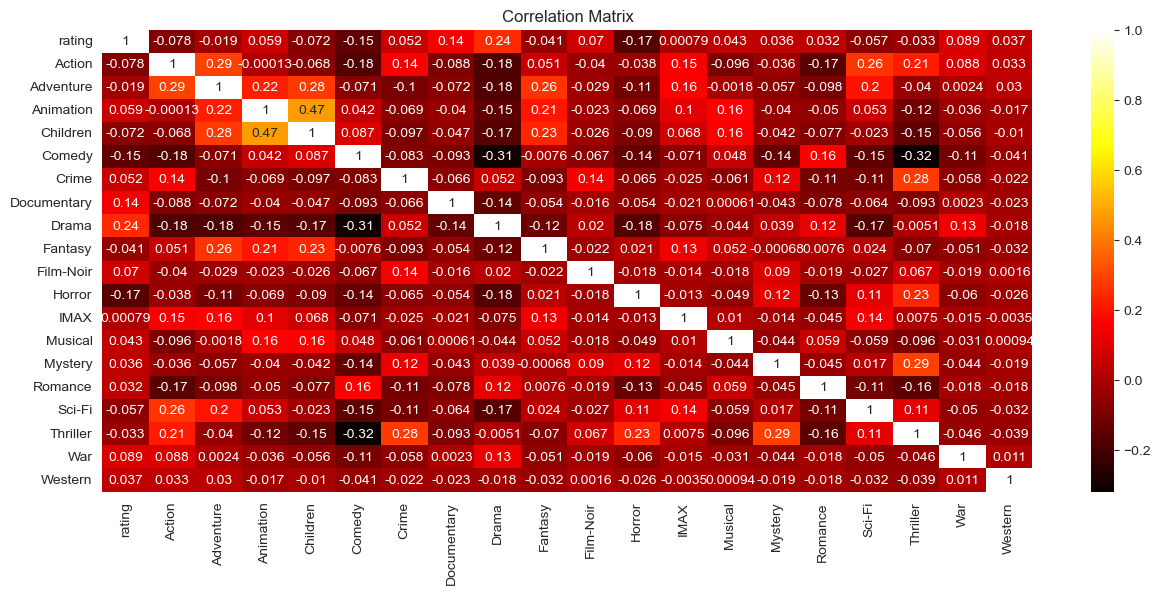

In [55]:
# Plot the correlation matrix
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='hot')
plt.title('Correlation Matrix')
plt.show()


None of the genres are strongly correlated with the average rating.

# Transform the data to reduce the skewness and make it more normal distribution.


Lets try to Transform the data to reduce the skewness and make it more normal distribution.


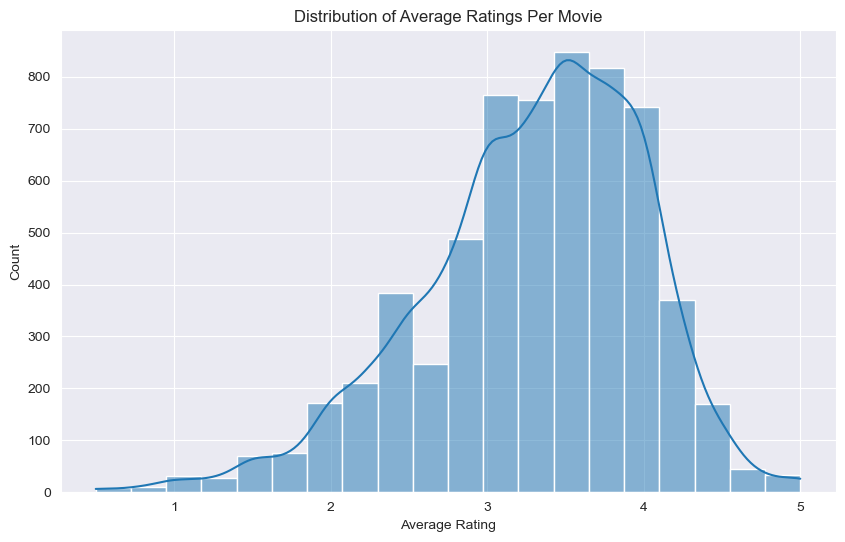

In [56]:
#Plotting the distribution of the average ratings per movie
plt.figure(figsize=(10, 6))
sns.histplot(average_ratings, bins=20, kde=True)
plt.title('Distribution of Average Ratings Per Movie')
plt.xlabel('Average Rating')
plt.show()



We believe that the data is normally distributed. So we will not apply any transformation to the data.

Since we have continuous feature lets for rating lets discretize it.

In [57]:
# Discretize the average ratings into 3 bins
movies_ratings_filtered['rating_category'] = pd.cut(movies_ratings_filtered['rating'], bins=[0, 2, 4, 5], labels=['low', 'medium', 'high'])
movies_ratings_filtered.head(3)

,movieId,title,userId,rating,Action,Adventure,Animation,Children,Comedy,Crime,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating_category
0,1,Toy Story (1995),1,4.0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,medium
1,1,Toy Story (1995),5,4.0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,medium
2,1,Toy Story (1995),7,4.5,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,high


In [58]:
# Create a StandardScaler instance
scaler = StandardScaler()

In [59]:
# Standardize the 'rating' feature
movies_ratings_filtered['rating_scaled'] = scaler.fit_transform(movies_ratings_filtered[['rating']])

In [60]:
movies_ratings_filtered.head()

,movieId,title,userId,rating,Action,Adventure,Animation,Children,Comedy,Crime,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating_category,rating_scaled
0,1,Toy Story (1995),1,4.0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,medium,0.460343
1,1,Toy Story (1995),5,4.0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,medium,0.460343
2,1,Toy Story (1995),7,4.5,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,high,0.943506
3,1,Toy Story (1995),15,2.5,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,medium,-0.989147
4,1,Toy Story (1995),17,4.5,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,high,0.943506


Models 

Since we need train and test set but with difffent features lets split the data into train and test set first. and we can use same train test val data for all the models.

In [61]:
X = movies_ratings_filtered.drop(['title', 'rating_category', 'rating_scaled'], axis=1)
y = movies_ratings_filtered['rating']

In [62]:
# Step 1: Split the data into training and test sets
X_train, X_temp, y_train, y_temp = train_test_split_sklearn(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 2: Further split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split_sklearn(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

X_train.shape, X_test.shape, y_train.shape, y_test.shape , X_val.shape, y_val.shape

((63032, 22), (13507, 22), (63032,), (13507,), (13507, 22), (13507,))

**FOR SVD**

In [63]:
# Modified the train and test set to include only the features that we want to use -- **SVD**
X_train_for_SVD = X_train[['userId', 'movieId', 'rating']]
X_test_for_SVD = X_test[['userId', 'movieId', 'rating']]
X_val_for_SVD = X_val[['userId', 'movieId', 'rating']]


In [64]:
# Removing unnecessary features from the train and test set
X_train = X_train.drop(['userId', 'movieId', 'rating'], axis=1)
X_test = X_test.drop(['userId', 'movieId', 'rating'], axis=1)
X_val = X_val.drop(['userId', 'movieId', 'rating'], axis=1)

#   For LinearRegression

In [65]:
def evaluate_regression_model(model, predictions, y_test):
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared: {r2}")

In [66]:
# Using Linear Regression
linear_model = LinearRegression()

In [67]:
X_train.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
89850,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0
94801,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
62885,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
78910,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
21125,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [68]:
linear_model.fit(X_train,y_train)

LinearRegression()

In [69]:
linear_model_pred = linear_model.predict(X_test)

In [70]:
#Model Evaluation 
evaluate_regression_model(linear_model,linear_model_pred,y_test)

Mean Squared Error (MSE): 1.0239756114737153
Root Mean Squared Error (RMSE): 1.01191680066778
Mean Absolute Error (MAE): 0.8062383077260341
R-squared: 0.044040230106884626


As our movie rating is from 0 - 5 MSE of 1.01 is not so good but its not bad also. (average squared difference between the estimated values and the actual value.)

RMSE(measure of the average error in the same units as the target variable): 

MAE( average absolute difference between predicted values and actual values.) : On average our predicition were only off by 0.8 

R-squared : is low , it indiciates that our features are not very effective 

In [71]:
# Evaluation on Validation set 
val_predictions_linear = linear_model.predict(X_val)

# Evaluate the model on the validation set
evaluate_regression_model(linear_model, val_predictions_linear, y_val)


Mean Squared Error (MSE): 1.0296561921836502
Root Mean Squared Error (RMSE): 1.014719760418437
Mean Absolute Error (MAE): 0.8087097260603625
R-squared: 0.03821392155546033


It is almost identical so lets try other methods 

Cause of low R-squared we need to find some other feature or another dataset , we will look into this in future 

# Random Forest Model

In [72]:
random_forest_model = RandomForestRegressor(random_state=42)

In [73]:
# Train 
random_forest_model.fit(X_train,y_train)


RandomForestRegressor(random_state=42)

In [74]:
rf_predication = random_forest_model.predict(X_test)

In [75]:
print("Evaluate Random Forest model")
evaluate_regression_model(random_forest_model, rf_predication, y_test)

Evaluate Random Forest model
Mean Squared Error (MSE): 0.9858045481078176
Root Mean Squared Error (RMSE): 0.9928769048113757
Mean Absolute Error (MAE): 0.785083828814468
R-squared: 0.07967584539202055


In [76]:
# Evaulation in Validation set 
rf_predication_val = random_forest_model.predict(X_val)
evaluate_regression_model(random_forest_model,rf_predication_val,y_val)

Mean Squared Error (MSE): 0.9919549398288633
Root Mean Squared Error (RMSE): 0.995969346831951
Mean Absolute Error (MAE): 0.7884710779506333
R-squared: 0.07343008393084394


The results from the Random Forest Regressor show some improvement over the Linear Regression model.
But for most part the prediction error and variance in data is same 

Lets try another model SVR
# Warning
It takes some time for SVR to run 

In [78]:
svr_model = make_pipeline(StandardScaler(), SVR())

In [79]:
# Train the model
svr_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())])

In [80]:
# Predict on the test set
svr_predictions_test = svr_model.predict(X_test)

In [81]:
# Evaluate the model on the test set
print("Evaluate SVM (SVR) model on Test Set")
evaluate_regression_model(svr_model, svr_predictions_test, y_test)

Evaluate SVM (SVR) model on Test Set
Mean Squared Error (MSE): 0.9994832340538256
Root Mean Squared Error (RMSE): 0.9997415836374045
Mean Absolute Error (MAE): 0.7752874719920495
R-squared: 0.06690574293756213


In [82]:
# Predict on the validation set
svr_predictions_val = svr_model.predict(X_val)

In [83]:
# Evaluate the model on the validation set
print("Evaluate SVM (SVR) model on Validation Set")
evaluate_regression_model(svr_model, svr_predictions_val, y_val)

Evaluate SVM (SVR) model on Validation Set
Mean Squared Error (MSE): 1.0148557266947722
Root Mean Squared Error (RMSE): 1.0074004797967748
Mean Absolute Error (MAE): 0.7822014101700338
R-squared: 0.05203880967808039


Looking at the result
it looks like it is also same as other two model 

# Comparing the models

# Since one of our goal is give recommendation 
Collaborative filtering can be used 
Note : Collaborative filtering algorithms focus on uncovering latent factors that explain observed preferences (ratings) by analyzing patterns of ratings across different users and movies. They don't directly incorporate additional item features (like genres) or user features (like age or location).

In [84]:
# Load the dataset into Surprise's format
reader = Reader(rating_scale=(1, 5))
# Convert the DataFrame to the list of tuples
trainset_list = [tuple(x) for x in X_train_for_SVD.to_numpy()]
testset_list = [tuple(x) for x in X_test_for_SVD.to_numpy()]
valset_list = [tuple(x) for x in X_val_for_SVD.to_numpy()]

In [85]:
trainset = Dataset.load_from_df(X_train_for_SVD, reader).build_full_trainset()

In [86]:
# Train the SVD model on the full training set
svd_model = SVD()

In [87]:
# Train the model on the trainset
svd_model.fit(trainset)

In [88]:
svd_data = Dataset.load_from_df(X_train_for_SVD, reader)
cross_val_results = cross_validate(svd_model, svd_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8728  0.8743  0.8704  0.8897  0.8849  0.8784  0.0075  
MAE (testset)     0.6748  0.6765  0.6690  0.6838  0.6793  0.6767  0.0049  
Fit time          0.26    0.43    0.26    0.26    0.24    0.29    0.07    
Test time         0.03    0.03    0.11    0.03    0.03    0.05    0.03    


Looking at this we can see that the distribution of data does not affect the performance of the model.
The low standard deviation in these metrics across the folds indicates that our model is stable and not overly sensitive to the specific way the data is split.
So lets try to predict on whole set.

In [89]:
# Test the model on the testset
svd_model_pred = svd_model.test(testset_list)

# Test the model on the validation set
val_predictions = svd_model.test(valset_list)
print("Evaluate SVD model on Test Set")
# Calculate and print RMSE and MAE for the test set
test_rmse = accuracy.rmse(svd_model_pred)
test_mae = accuracy.mae(svd_model_pred)
print("Evaluate SVD model on VAl Set")
# Calculate and print RMSE and MAE for the validation set
val_rmse = accuracy.rmse(val_predictions)
val_mae = accuracy.mae(val_predictions)

Evaluate SVD model on Test Set
RMSE: 0.8765
MAE:  0.6746
Evaluate SVD model on VAl Set
RMSE: 0.8757
MAE:  0.6756


The SVD algorithm demonstrates good and consistent predictive performance in terms of RMSE and MAE.


In our trial we removed the user 1 and movie 1 from our dataset. and we tried to predict using svd model it predicted 4.05 which is very close to the original rating 4.0 

Since we have 4 models we will try to combine them and see if we can get better result 
Looking at feature we believe that SVD and Random Forest will be good for our model , as SVD is good for collaborative filtering and Random Forest is good for classification. 

# Lets try to combine the models

In [90]:
# Extract the estimated ratings from SVD predictions
svd_estimated_ratings = [pred.est for pred in svd_model_pred]

In [91]:
combined_predictions = [(svd_est + rf_est)/2 for svd_est, rf_est in zip(svd_estimated_ratings, rf_predication)]

In [92]:
print(len(combined_predictions))
print(len(y_test))


13507
13507


In [93]:
# Evaluate the combined predictions
# Assuming y_test contains the actual ratings
print("Evaluate Combined Predictions")
evaluate_regression_model(None, combined_predictions, y_test)

Evaluate Combined Predictions
Mean Squared Error (MSE): 0.8076007885214268
Root Mean Squared Error (RMSE): 0.8986661162642257
Mean Absolute Error (MAE): 0.7003006826279564
R-squared: 0.24604272278582562


Looking at the result we can see that the combined model is not better than the individual models.
**BUT** R-squared is better than the individual models. 

 Lets test the combined model on Ourself and see how good does it work as a recommendation system. 

In [94]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [95]:
# Lets create a user that is not in our dataset 
user_id = 1000
# Lets say that this user has watched and rated 10 movies
user_ratings = [
    (user_id, 1, 4),
    (user_id, 2, 4),
    (user_id, 89745, 4.5),
    (user_id, 122912, 5),
    (user_id, 122918, 5),
    (user_id, 122922, 5),
    (user_id, 187593, 3),
    (user_id, 187031, 3),
    (user_id, 179819, 2),
    (user_id, 167706, 2)
]

In [96]:
# User ratings split
train_ratings = user_ratings[:5]  # First 5 ratings for training
test_ratings = user_ratings[5:]   # Last 5 ratings for testing


In [97]:

# Add the new user's training ratings to your existing dataset
new_user_ratings_df = pd.DataFrame(train_ratings, columns=['userId', 'movieId', 'rating'])
updated_df = pd.concat([movies_ratings_filtered, new_user_ratings_df])

# Retrain the SVD model
svd_model.fit(trainset)


In [98]:
# Load the updated dataset into Surprise
reader = Reader(rating_scale=(1, 5))
updated_data = Dataset.load_from_df(updated_df[['userId', 'movieId', 'rating']], reader)
trainset = updated_data.build_full_trainset()

In [99]:
# Retrain the SVD model
svd_model = SVD()
svd_model.fit(trainset)

In [100]:
# Predict the ratings for the test ratings
test_predictions = svd_model.test(test_ratings)

# Calculate and print RMSE and MAE for the test set
test_rmse = accuracy.rmse(test_predictions)
test_mae = accuracy.mae(test_predictions)


RMSE: 1.1297
MAE:  1.0362


In [101]:
# Extracting prediction details
predictions_data = []
for prediction in test_predictions:
    predictions_data.append({
        "user_id": prediction.uid,
        "movie_id": prediction.iid,
        "actual_rating": prediction.r_ui,
        "estimated_rating": prediction.est,
        "was_impossible": prediction.details['was_impossible']
    })

# Create a DataFrame from the predictions
predictions_df = pd.DataFrame(predictions_data)

# Display the DataFrame
print(predictions_df)


   user_id  movie_id  actual_rating  estimated_rating  was_impossible
0     1000    122922              5          4.079540           False
1     1000    187593              3          3.749202           False
2     1000    187031              3          3.451441           False
3     1000    179819              2          3.319889           False
4     1000    167706              2          3.739838           False


Since our goal was to build a recommendation system, we will use the SVD model to predict the ratings for the movies that the new user has not yet rated.
Even though the estimated ratings are not very accurate, we can still use them to recommend movies to the new user. 

Some extra notes :
We did not use PCA because it is not good for collaborative filtering. also we did not had a lot of features to reduce. 
**Mistake**
We should have used another dataset to get more features. 
Initially we thought that we can use the tags dataset to get more features but we found out that there are a lot of movies that are not in our movies_ratings_filtered dataset.
So we decided not to use it.

**Trial**
We tried to get more features from imdb api but it took a lot of time just for some movies and we had about 9000 movies. So we decided not to get more features from imdb api. 

We could have make our model better if we had more features. SO we will try to get more features in future.
Also , if possible we should have tried to give more weight to the movies that are rated by more users. 


# Ideas for future work 
1. We can try to get more features from imdb api.
2. We can try to give more weight to the movies that are rated by more users.
3. We can try to use another dataset to get more features.

We have a model that can predict the rating for a movie that a user has not yet rated. We can use this model to recommend movies to the user. So , we can say that we have a recommendation system, like Netflix or Amazon Prime. 